In [2]:
import time
import sys
import os
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import warnings
warnings.simplefilter("ignore")

In [3]:
train_img= r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training"
labels = os.listdir(train_img)
print("No. of labels in the Training set: {}".format(len(labels)))
print("-----------------")
os.chdir(train_img)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(train_img+ '//' +label))))

No. of labels in the Training set: 2
-----------------
colon_aca, 3493 files
colon_n, 3487 files


In [4]:
test_img = r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Testing"
labels = os.listdir(train_img)
print("No. of labels in the Testing set: {}".format(len(labels)))
print("-----------------")
os.chdir(test_img)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(test_img+ '//' +label))))

No. of labels in the Testing set: 2
-----------------
colon_aca, 1003 files
colon_n, 1003 files


Next, we will plot 10 images aca tumor training images

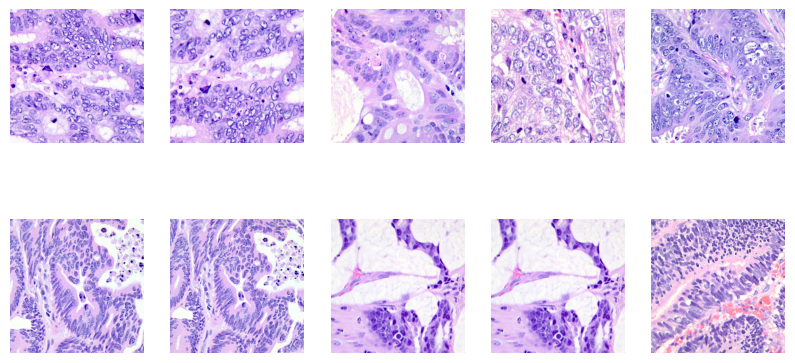

In [5]:
colon_aca = r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training\colon_aca"
sub_class = os.listdir(colon_aca)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(colon_aca,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

Since this dataset already contains augmented images, so further data augmentation will not be required.  
We will use the ImageDataGenerator class from Keras to split the data into training and validation sets.

In [6]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
                                


train_generator = img_datagen.flow_from_directory(train_img,
                                                  class_mode='binary',
                                                 shuffle=True,
                                                 batch_size=32,
                                                 subset='training',
                                                 target_size=(100,100))
                                                 
valid_generator = img_datagen.flow_from_directory(test_img,
                                                 shuffle=True,
                                                  class_mode='binary',
                                                  batch_size=16,
                                                  subset='validation',
                                                 target_size=(100,100))

# Create a lablel_map dictionary that we will use for predicting on unseen data
label_map = (train_generator.class_indices)
print('Label mappings:\n')
label_map

Found 5585 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Label mappings:



{'colon_aca': 0, 'colon_n': 1}

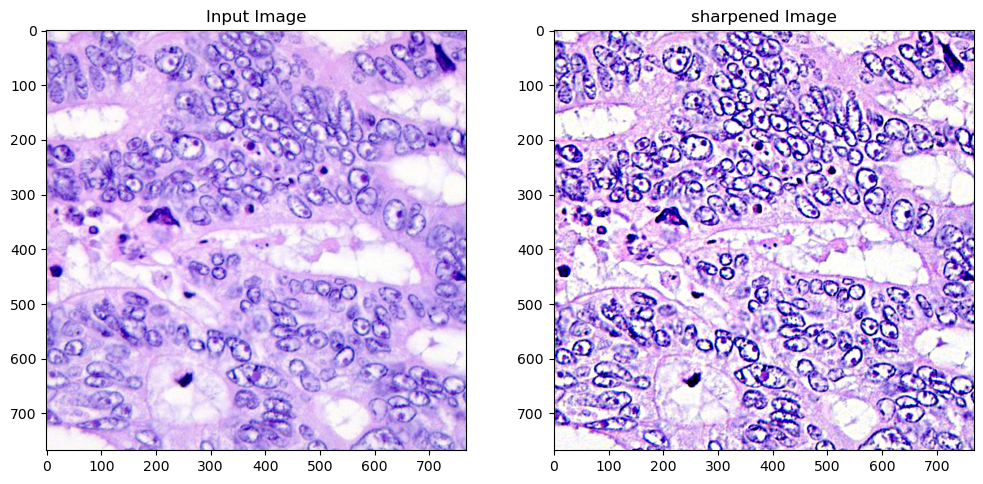

In [8]:
from skimage import io
from skimage.filters import unsharp_mask

img = io.imread(r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training\colon_aca\colonca1508.jpeg")

#sharpened = unsharp_mask(image0, radius=1.0, amount=1.0)
sharped_img = unsharp_mask(img, radius=5, amount=2)


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(sharped_img, cmap='gray')
ax2.title.set_text('sharpened Image')

plt.show()

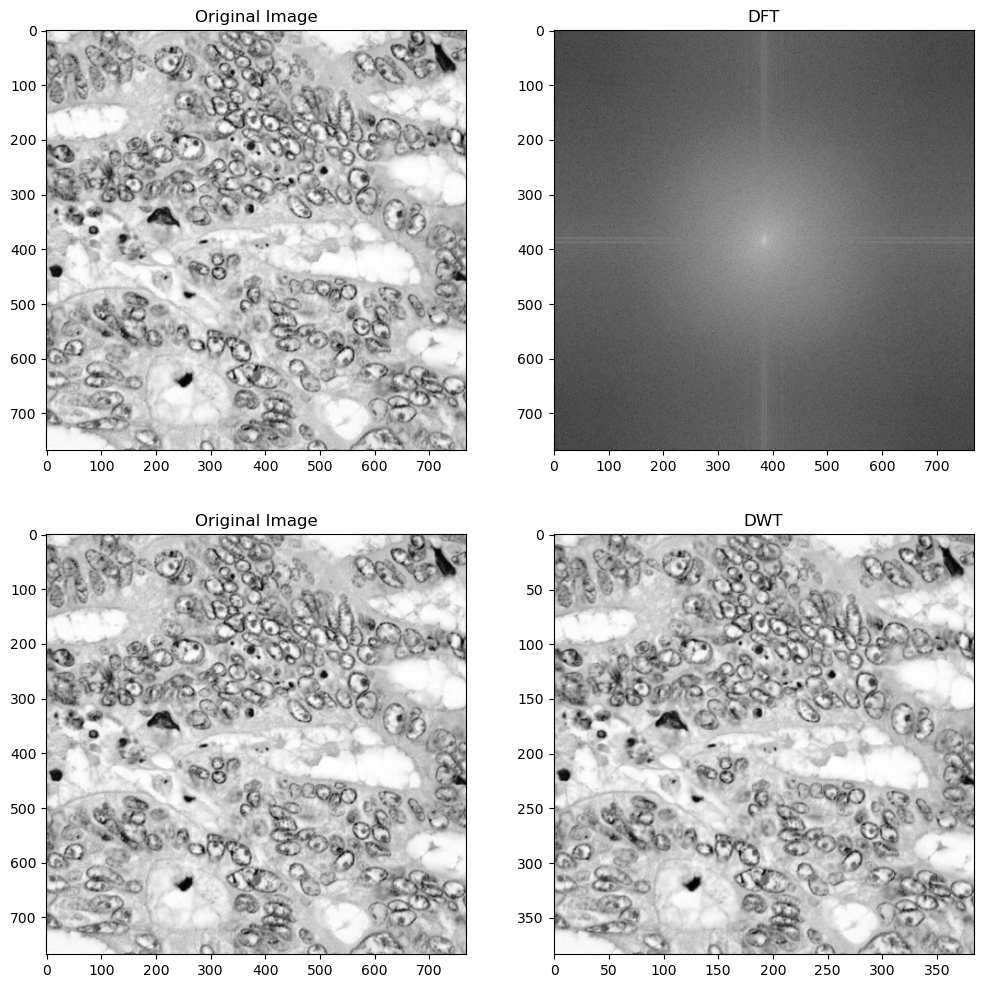

In [10]:
import pywt
# Load image
img = cv2.imread(r'C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training\colon_aca\colonca1508.jpeg',cv2.IMREAD_GRAYSCALE)
fig = plt.figure(figsize=(12, 12))
# Display the original image
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Compute the 2D DFT
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Compute the magnitude spectrum
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# Display the processed image
plt.subplot(2, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('DFT')

# Compute the 2D DWT
coeffs2 = pywt.dwt2(img, 'haar')
cA, (cH, cV, cD) = coeffs2

# Display the processed image
plt.subplot(2, 2, 4)
plt.imshow(cA, cmap='gray')
plt.title('DWT')

# Display the unprocessed image
plt.subplot(2, 2, 3)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.show()

##  CNN model 
 

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))


model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [10]:
callbacks_list = [EarlyStopping( monitor='accuracy', patience=5, ),
                  ModelCheckpoint( filepath='/content/drive/MyDrive/train results/models/keras_colon_cancer_classification.h5',
                                  monitor='test_accuracy', save_best_only=True,verbose = 1, ) ]

Next, we compile the model using the adam optimizer and the categoical_crossentropy loss function since this is a multi-class classification problem.

In [11]:
model.compile(optimizer=RMSprop(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, validation_data=valid_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_steps=valid_generator.n//valid_generator.batch_size,
                    callbacks=[callbacks_list],
                    epochs=3)


Epoch 1/3
174/174 [==============================] - 104s 590ms/step - loss: 0.6942 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/3
174/174 [==============================] - 109s 627ms/step - loss: 0.6828 - accuracy: 0.5629 - val_loss: 0.5169 - val_accuracy: 0.7950
Epoch 3/3
174/174 [==============================] - 103s 590ms/step - loss: 0.6325 - accuracy: 0.6530 - val_loss: 0.3924 - val_accuracy: 0.8575


In [19]:
def show_result(history): 
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['accuracy']
    temp_vloss = temph['val_accuracy']
    temp_vacc = temph['val_accuracy']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index

    # Print the result from the Highest val_acc epoch
    print('Highest validation accuracy in Epoch: %s'%str(max_index+1))
    print('Train accuracy: %s'%temp_acc[max_index])
    print('Validation accuracy: %s'%temp_vacc[max_index])

    print('--------------------------------------------------')
    
    # Print the result from the last epoch
    print('Last train Epoch')
    print('Train accuracy: %s'%history.history['accuracy'][-1])
    print('Validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training accuracy')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation accuracy')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

Highest validation accuracy in Epoch: 3
Train accuracy: 0.652980387210846
Validation accuracy: 0.8575000166893005
--------------------------------------------------
Last train Epoch
Train accuracy: 0.652980387210846
Validation accuracy: 0.8575000166893005


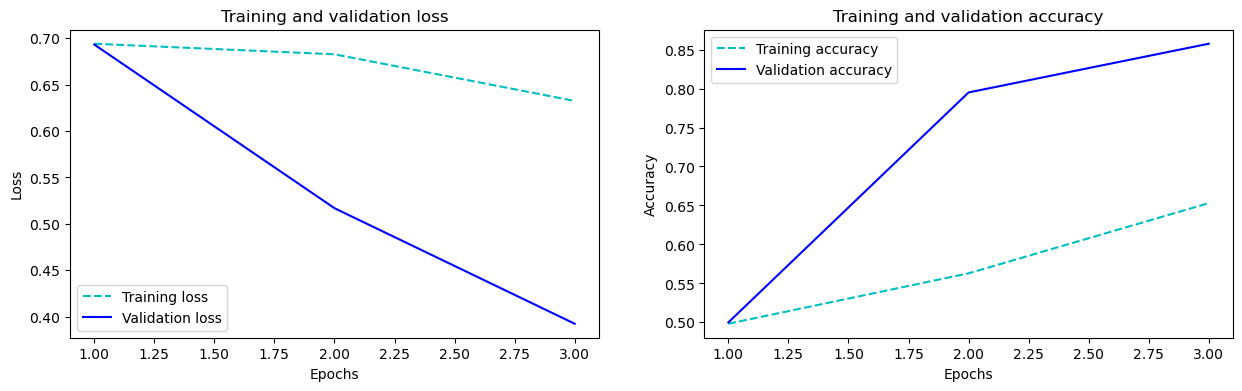

In [20]:
show_result(history)

### Plotting model training and validation curves.


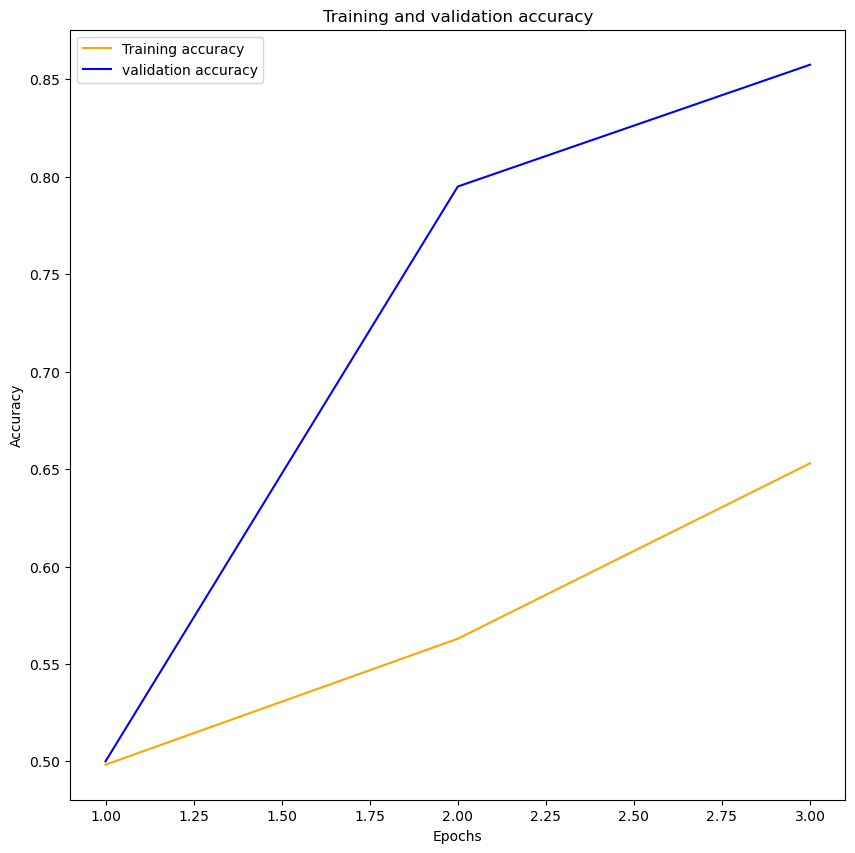

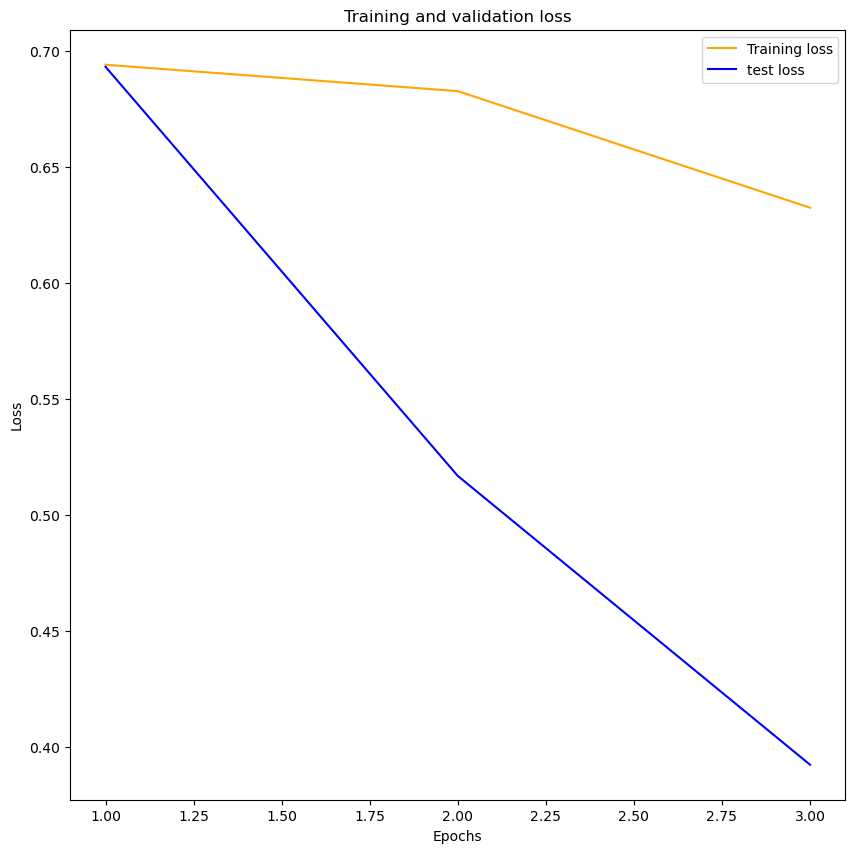

In [21]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_accuracy) + 1)
plt.figure(figsize=(10,10))
plt.plot(epochs, training_accuracy, 'orange', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10,10))

plt.plot(epochs, training_loss, 'orange', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()